In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
#from keras.layers.core import MaxoutDense
from models.maxout_layers import Maxout1D

#dropout_enable = False

#model_file = "DL1_AntiKt4EMTopo_dropout" if dropout_enable else "DL1_AntiKt4EMTopo"

model = tf.keras.models.load_model("DL1_AntiKt4EMTopo")
model_dropout = tf.keras.models.load_model("DL1_AntiKt4EMTopo_dropout")
#test_model.summary()

In [2]:
model_dropout(inputs=np.random.random((5, 41)), training=False)


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.18218191, 0.5798462 , 0.23797187],
       [0.24413493, 0.5548208 , 0.2010443 ],
       [0.42208982, 0.45337594, 0.12453424],
       [0.1679932 , 0.58424383, 0.24776304],
       [0.1679932 , 0.58424383, 0.24776304]], dtype=float32)>

In [3]:
import h5py
hf = h5py.File("../FTAGUQ/input/MC16_ttbar-test-ujets.h5", 'r')
X_test, Y_test = hf['X_test'][:], hf['Y_test'][:]
hf.close()   

In [4]:
re_dropout = model_dropout(np.array(1000*[X_test[0]]), training=False)
re = model(X_test, training=False)

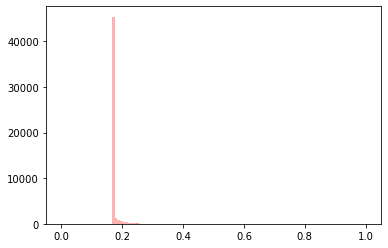

In [13]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the histogram of the data
n, bins, patches = ax.hist(re_dropout.numpy()[:,2], 100, density=True, alpha=0.3)
n, bins, patches =ax.hist(re.numpy()[:,0],100, alpha=0.3, color='red')

In [14]:
def DL1_socre(softmax_prob): 
    return np.log(softmax_prob[:,2]/(0.08*softmax_prob[:,1] + 0.92*softmax_prob[:,0]))  

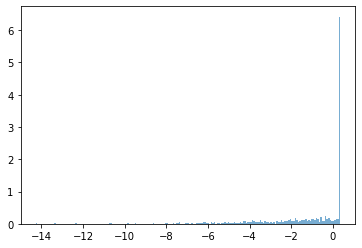

In [15]:
_ =plt.hist(DL1_socre(re_dropout.numpy()), 200,  density=True, alpha=0.6)

In [16]:
np.sum(DL1_socre(re.numpy())>0.46)/len(re.numpy()[:,0])

0.0

In [9]:
DL1_socre(re.numpy())

array([0.20770992, 0.20770992, 0.20770992, ..., 0.20770992, 0.20770992,
       0.20770992], dtype=float32)